### Análise realizada com base nos artigos: 
#### GBM - https://beta.vu.nl/nl/Images/werkstuk-dmouj_tcm235-91341.pdf
#### Vasicek e CIR - https://web.mst.edu/~bohner/fim-10/fim-chap4.pdf

#### Bibliotecas necessárias

In [2]:
import numpy as np #biblioteca para operações com vetores e geração de aleatórios
import matplotlib.pyplot as plt #geração de gráficos
from matplotlib import style, gridspec
import datetime as dt #tratamento de formato de datas
from dateutil import relativedelta #operações com datas
import pandas as pd #geração e manipulação de tabelas (dataframes)
from scipy import stats #tratamento estatístico dos dados
from numba import jit #otimização de loops
import copy
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
style.use('ggplot')

# Simulação de Monte Carlo para precificação do ativo ao longo do tempo

### $\underline{\text{GBM}}$

##  $S_t = S_{t-1}\cdot e^{(\mu-\frac{\sigma^2}{2})dt + \sigma\epsilon\sqrt{dt}}$

onde $S_t$ representa o preço do ativo em $t$ e $\epsilon$ representa a variável estocástica, gerada a partir de uma Distribuição Normal de variância $\sigma^2=1$  e média $\mu=0$.

### $\underline{\text{Vasicek}}$

## $\text{d}r = \kappa(\gamma-r_{t-1})\text{d}t + \sigma\epsilon$

onde $S_t$ representa o preço do ativo em $t$, $\kappa$ a velocidade de reversão à média, $\gamma$ a taxa de longo prazo e $\epsilon$ a variável estocástica, gerada a partir de uma Distribuição Normal de variância $\sigma^2=1$  e média $\mu=0$.

### $\underline{\text{CIR}}$

## $\text{d}r = \kappa(\gamma-r_{t-1})\text{d}t + \sigma\sqrt{r_{t-1}}\epsilon\sqrt{\text{d}t}$

onde $r_t$ representa a taxa de variação do ativo em $t$, $\kappa$ a velocidade de reversão à média, $\gamma$ a taxa de longo prazo e $\epsilon$ a variável estocástica, gerada a partir de uma Distribuição Normal de variância $\sigma^2=1$  e média $\mu=0$.

In [3]:
@jit(nogil=True)
def gbm(dict_ativo):
    spot = dict_ativo['spot']
    drift = dict_ativo['drift']
    daily_vol = dict_ativo['daily_vol']
    random_matrix = dict_ativo['random_matrix']
    d_t = 1./365
    prices = random_matrix.copy()
    prices[0,:] = spot #insere o spot na primeira linha de todas as colunas    
    for i in range(1,len(prices)):
        for j in range(len(prices[i])):
            prior = prices[i-1][j]
            random_value = random_matrix[i][j]
            prices[i][j] = prior*np.exp((drift-daily_vol**2/2)*d_t+daily_vol*random_value*np.sqrt(d_t))
    return prices
    

@jit(nogil=True)
def vasicek(dict_ativo):
    spot = dict_ativo['spot']
    reversion_speed = dict_ativo['reversion_speed']
    long_term_rate = dict_ativo['long_term_rate']
    daily_vol = dict_ativo['daily_vol']
    random_matrix = dict_ativo['random_matrix']
    d_t = 1./365
    prices = random_matrix.copy()
    prices[0,:] = spot #insere o spot na primeira linha de todas as colunas    
    for i in range(1,len(prices)):
        for j in range(len(prices[i])):
            prior = prices[i-1][j]
            random_value = random_matrix[i][j]
            prices[i][j] = prior+reversion_speed*(long_term_rate-prior)*d_t + daily_vol*random_value
    return prices

@jit(nogil=True)
def cir(dict_ativo):
    spot = dict_ativo['spot']
    reversion_speed = dict_ativo['reversion_speed']
    long_term_rate = dict_ativo['long_term_rate']
    daily_vol = dict_ativo['daily_vol']
    random_matrix = dict_ativo['random_matrix']
    d_t = 1./365
    prices = random_matrix.copy()
    prices[0,:] = spot #insere o spot na primeira linha de todas as colunas    
    for i in range(1,len(prices)):
        for j in range(len(prices[i])):
            prior = prices[i-1][j]
            random_value = random_matrix[i][j]
            prices[i][j] = prior+reversion_speed*(long_term_rate-prior)*d_t + \
                                                daily_vol*random_value*np.sqrt(prior)*np.sqrt(d_t)
    return prices

@jit(nogil=True)
def perc_acima(array):
    spot = array[0][0]
    n_acima = np.where(array[-1] > spot)
    return np.size(n_acima)/np.size(array[-1])

@jit(nogil=True)
def perc_abaixo(array):
    spot = array[0][0]
    n_abaixo = np.where(array[-1] < spot)
    return np.size(n_abaixo)/np.size(array[-1])


##############################################################################################################

def precificacao(DICT_GBM,DICT_CIR,DICT_VASICEK):
    for i in DICT_GBM:
        prices_array = gbm(DICT_GBM[i]) 
        DICT_GBM[i]["prices"] = prices_array 
        DICT_GBM[i]["percentis"] = np.percentile(prices_array,[1,5,10,50,90,95,99],axis=1).transpose()
        DICT_GBM[i]['porc_acima_spot'] = perc_acima(prices_array)
        DICT_GBM[i]['porc_abaixo_spot'] = perc_abaixo(prices_array)

    for i in DICT_CIR:
        prices_array = cir(DICT_CIR[i]) 
        DICT_CIR[i]["prices"] = prices_array 
        DICT_CIR[i]["percentis"] = np.percentile(prices_array,[1,5,10,50,90,95,99],axis=1).transpose()
        DICT_CIR[i]['porc_acima_spot'] = perc_acima(prices_array)
        DICT_CIR[i]['porc_abaixo_spot'] = perc_abaixo(prices_array)

    for i in DICT_VASICEK:
        prices_array = vasicek(DICT_VASICEK[i]) 
        DICT_VASICEK[i]["prices"] = prices_array 
        DICT_VASICEK[i]["percentis"] = np.percentile(prices_array,[1,5,10,50,90,95,99],axis=1).transpose()
        DICT_VASICEK[i]['porc_acima_spot'] = perc_acima(prices_array)
        DICT_VASICEK[i]['porc_abaixo_spot'] = perc_abaixo(prices_array)

def recalcula_ativo(ativo,params):
    if ativo in GBM_ATIVOS:
        drift = params[0]
        daily_vol = params[1]
        DICT_GBM[ativo]["drift"] = drift
        DICT_GBM[ativo]["daily_vol"] = daily_vol
        prices_array = gbm(DICT_GBM[ativo]) 
        DICT_GBM[ativo]["prices"] = prices_array 
        DICT_GBM[ativo]["percentis"] = np.percentile(prices_array,[1,5,10,50,90,95,99],axis=1).transpose()
        DICT_GBM[ativo]['porc_acima_spot'] = perc_acima(prices_array)
        DICT_GBM[ativo]['porc_abaixo_spot'] = perc_abaixo(prices_array)
    elif ativo in CIR_ATIVOS:
        reversion_speed = params[0]
        long_term_rate = params[1]
        daily_vol = params[2]
        DICT_CIR[ativo]["reversion_speed"] = reversion_speed
        DICT_CIR[ativo]["long_term_rate"] = long_term_rate
        DICT_CIR[ativo]["daily_vol"] = daily_vol
        prices_array = cir(DICT_CIR[ativo]) 
        DICT_CIR[ativo]["prices"] = prices_array 
        DICT_CIR[ativo]["percentis"] = np.percentile(prices_array,[1,5,10,50,90,95,99],axis=1).transpose()
        DICT_CIR[ativo]['porc_acima_spot'] = perc_acima(prices_array)
        DICT_CIR[ativo]['porc_abaixo_spot'] = perc_abaixo(prices_array)
    elif ativo in VASICEK_ATIVOS:
        reversion_speed = params[0]
        long_term_rate = params[1]
        daily_vol = params[2]
        DICT_VASICEK[ativo]["reversion_speed"] = reversion_speed
        DICT_VASICEK[ativo]["long_term_rate"] = long_term_rate
        DICT_VASICEK[ativo]["daily_vol"] = daily_vol
        prices_array = vasicek(DICT_VASICEK[ativo]) 
        DICT_VASICEK[ativo]["prices"] = prices_array 
        DICT_VASICEK[ativo]["percentis"] = np.percentile(prices_array,[1,5,10,50,90,95,99],axis=1).transpose()
        DICT_VASICEK[ativo]['porc_acima_spot'] = perc_acima(prices_array)
        DICT_VASICEK[ativo]['porc_abaixo_spot'] = perc_abaixo(prices_array)
        
def retornar_inicio():
    global DICT_GBM
    global DICT_GBM_INICIAL
    global DICT_CIR
    global DICT_CIR_INICIAL
    global DICT_VASICEK
    global DICT_VASICEK_INICIAL
    
    DICT_GBM = copy.deepcopy(DICT_GBM_INICIAL)
    DICT_CIR = copy.deepcopy(DICT_CIR_INICIAL)
    DICT_VASICEK = copy.deepcopy(DICT_VASICEK_INICIAL)
    
    return True

def plota_novo_ativo(botao):
    
    global dropdown_ativos
    global drift_box
    global vol_box
    global long_term_rate_box
    global reversion_speed_box
    global DICT_GBM
    global DICT_CIR
    global DICT_VASICEK
    
    clear_output()
    
    if dropdown_ativos.value == '':
        display(widgets.HBox([dropdown_ativos,botao_troca_ativo]))
        display(widgets.HBox([reversion_speed_box,long_term_rate_box]))
        display(widgets.HBox([vol_box,drift_box]))
        
    else:
        display(widgets.HBox([dropdown_ativos,botao_troca_ativo]))
        display(widgets.HBox([reversion_speed_box,long_term_rate_box]))
        display(widgets.HBox([vol_box,drift_box,botao_recalcula_percentis]))
    
    if dropdown_ativos.value == '':
        vol_box.value = 0
        drift_box.value = 0
        reversion_speed_box.value = 0
        long_term_rate_box.value = 0  
        vol_box.disabled = True
        drift_box.disabled = True
        reversion_speed_box.disabled = True
        long_term_rate_box.disabled = True

    
    elif dropdown_ativos.value in GBM_ATIVOS:
        ativo = dropdown_ativos.value
        vol_box.value = round(DICT_GBM[ativo]['daily_vol'],5)
        drift_box.value = round(DICT_GBM[ativo]['drift'],5)
        reversion_speed_box.value = 0
        long_term_rate_box.value = 0
        vol_box.disabled = False
        drift_box.disabled = False
        reversion_speed_box.disabled = True
        long_term_rate_box.disabled = True
        percentis = pd.DataFrame(DICT_GBM[ativo]['percentis'],columns=[1,5,10,50,90,95,99])
        acima = DICT_GBM[ativo]['porc_acima_spot']
        abaixo = DICT_GBM[ativo]['porc_abaixo_spot'] 
        prices = DICT_GBM[ativo]['prices']
        spot = DICT_GBM[ativo]['spot']

    elif dropdown_ativos.value in CIR_ATIVOS:
        ativo = dropdown_ativos.value
        vol_box.value = round(DICT_CIR[ativo]['daily_vol'],5)
        reversion_speed_box.value = round(DICT_CIR[ativo]['reversion_speed'],5)
        long_term_rate_box.value = round(DICT_CIR[ativo]['long_term_rate'],5)
        drift_box.value = 0
        vol_box.disabled = False
        drift_box.disabled = True
        reversion_speed_box.disabled = False
        long_term_rate_box.disabled = False
        percentis = pd.DataFrame(DICT_CIR[ativo]['percentis'],columns=[1,5,10,50,90,95,99])
        acima = DICT_CIR[ativo]['porc_acima_spot']
        abaixo = DICT_CIR[ativo]['porc_abaixo_spot'] 
        prices = DICT_CIR[ativo]['prices']
        spot = DICT_CIR[ativo]['spot']
    
    elif dropdown_ativos.value in VASICEK_ATIVOS:
        ativo = dropdown_ativos.value
        vol_box.value = round(DICT_VASICEK[ativo]['daily_vol'],5)
        reversion_speed_box.value = round(DICT_VASICEK[ativo]['reversion_speed'],5)
        long_term_rate_box.value = round(DICT_VASICEK[ativo]['long_term_rate'],5) 
        drift_box.value = 0
        vol_box.disabled = False
        drift_box.disabled = True
        reversion_speed_box.disabled = False
        long_term_rate_box.disabled = False
        percentis = pd.DataFrame(DICT_VASICEK[ativo]['percentis'],columns=[1,5,10,50,90,95,99])
        acima = DICT_VASICEK[ativo]['porc_acima_spot']
        abaixo = DICT_VASICEK[ativo]['porc_abaixo_spot'] 
        prices = DICT_VASICEK[ativo]['prices']
        spot = DICT_VASICEK[ativo]['spot']
    
    if dropdown_ativos.value == '':
        return False
    else:   
        
        last_values = prices[-1]
        font = {'family': 'monospace',
        'color':  'darkred',
        'weight': 'bold',
        'size': 14
#         'bbox': dict(boxstyle='round', facecolor='gray', alpha=0.2)
       } 
        
        plt.figure(figsize=[15,8])
        gs = gridspec.GridSpec(1, 2, width_ratios=[6, 1])
        ax1 = plt.subplot(gs[0])
        plt.title("Percentis - %s"%(ativo),fontsize=18)
        plt.margins(x=0.1)
        plt.plot(ARRAY_STEPDATES,percentis[99],label="Percentil 99",c="#2e39a7",alpha=0.3)
        plt.plot(ARRAY_STEPDATES,percentis[95],label="Percentil 95",c="#061bf0")
        plt.plot(ARRAY_STEPDATES,percentis[90],label="Percentil 90",c="#3041f1",alpha=0.3)
        plt.plot(ARRAY_STEPDATES,percentis[50],label="Percentil 50",c="#8A2BE2")
        plt.plot(ARRAY_STEPDATES,percentis[10],label="Percentil 10",c="#f04a4a",alpha=0.3)
        plt.plot(ARRAY_STEPDATES,percentis[5],label="Percentil 5",c="#f90303")
        plt.plot(ARRAY_STEPDATES,percentis[1],label="Percentil 1",c="#bf2121",alpha=0.3)
        
        plt.legend(loc='upper left',prop={'size':12})
        plt.margins(x=0.01)
        
        ymin,ymax = plt.ylim()

        ax2 = plt.subplot(gs[1])

        xmin,xmax=min(last_values),max(last_values)
        
#         mean,std = stats.norm.fit(last_values)
        mean = np.nanmean(last_values)
        std = np.nanstd(last_values)
        x = np.linspace(xmin,xmax,1000)
        norm = stats.norm.pdf(x,mean,std)

        plt.plot(norm,x,color='darkred',linewidth=2,label='Distribuição \ndos Cenários')
        plt.xticks([],[])

        plt.hist(last_values,bins=50,density=True,orientation='horizontal',alpha=0.4,color='darkred')
        ax2.yaxis.tick_right()
        plt.tight_layout(pad=0)
        plt.ylim(ymin,ymax)
        plt.legend(loc='lower right')
        # plt.subplots_adjust(left=0.5,right=0.6)
        
        text = \
r'''
 Cenários em 
relação ao spot
  $\uparrow$ %.1f%%
  $\downarrow$ %.1f%%
'''%(acima*100,abaixo*100)
        plt.text(0.1,0.9999,s=text,verticalalignment='top', fontdict=font,transform=ax2.transAxes)

        plt.show()

    
    box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='flex-end',
                width='90%')
    display(widgets.HBox(children=[botao_reset],layout=box_layout))
    
    return True

def recalcula_percentis(botao):
    
    clear_output()
    
    global dropdown_ativos
    global drift_box
    global vol_box
    global long_term_rate_box
    global reversion_speed_box
    global DICT_GBM
    global DICT_CIR
    global DICT_VASICEK
    
    ativo = dropdown_ativos.value
    
    if ativo in GBM_ATIVOS:
        recalcula_ativo(ativo,[drift_box.value,vol_box.value])
        plota_novo_ativo(botao)
        
    elif ativo in CIR_ATIVOS:
        recalcula_ativo(ativo,[reversion_speed_box.value,long_term_rate_box.value,vol_box.value])
        plota_novo_ativo(botao)
        
    elif ativo in VASICEK_ATIVOS:
        recalcula_ativo(ativo,[reversion_speed_box.value,long_term_rate_box.value,vol_box.value])
        plota_novo_ativo(botao)        
    
    return True           

def reset_dicts(botao):
    
    global DICT_GBM
    global DICT_CIR
    global DICT_VASICEK
    global dropdown_ativos
    retornar_inicio()
    plota_novo_ativo(botao)
    
    return True    

## Importação manual dos dados de mercado

#### Importar os dados de mercado manualmente do ativo desejado

A formatação de entrada esperada é a encontrada ao baixar os dados históricos de um ativo pelo site:
https://br.investing.com/

$\underline{\text{NÃO ALTERAR O NOME DO ARQUIVO BAIXADO}}$

In [4]:
#####################################################################

GBM_ATIVOS = [] 
CIR_ATIVOS = ['USD_BRL']
VASICEK_ATIVOS = []

NUM_CENAR = 1000 #qtde de simulações realizadas 
NUM_YEARS = 10

#####################################################################

DICT_GBM,DICT_CIR,DICT_VASICEK = {},{},{}
DF_GERAL = pd.DataFrame()
DF_RETURNS = pd.DataFrame()

today = dt.date.today()

dateparser = lambda x: pd.to_datetime(x, format='%d.%m.%Y')

for ativo in CIR_ATIVOS:
    _filename = "C:\\Users\\negri\\Downloads\\%s Dados Históricos.csv"%ativo
    #lê o csv e transforma em um dataframe, já realizando as formatações necessárias
    dados = pd.read_csv(_filename,skipinitialspace = True, \
                    decimal = ",", quotechar = '"', thousands = ".",
                    parse_dates=['Data'], date_parser=dateparser)
    dados = dados.sort_values(by=['Data'],ignore_index=True) #ordena os dados em ordem crescente
    dados = dados.tail(501).reset_index(drop=True) #utiliza apenas as 500 últimas datas e remove as outras
    returns = dados['Último'].pct_change()[1:]
    drift,daily_vol = stats.norm.fit(returns) #média e desvio padrão
    spot = dados['Último'].iloc[-1]
    DICT_CIR[ativo] = {'reversion_speed': 0.023, 'long_term_rate': 8.8998, 'daily_vol': 0.411, 'spot': spot}
    DF_GERAL[ativo] = dados['Último']
    DF_RETURNS[ativo] = returns

for ativo in GBM_ATIVOS:
    _filename = "C:\\Users\\negri\\Downloads\\%s Dados Históricos.csv"%ativo
    #lê o csv e transforma em um dataframe, já realizando as formatações necessárias
    dados = pd.read_csv(_filename,skipinitialspace = True, \
                    decimal = ",", quotechar = '"', thousands = ".",
                    parse_dates=['Data'], date_parser=dateparser)
    dados = dados.sort_values(by=['Data'],ignore_index=True) #ordena os dados em ordem crescente
    dados = dados.tail(501).reset_index(drop=True) #utiliza apenas as 500 últimas datas e remove as outras
    returns = dados['Último'].pct_change()[1:]
    drift,daily_vol = stats.norm.fit(returns) #média e desvio padrão
    spot = dados['Último'].iloc[-1]
    DICT_GBM[ativo] = {'drift': drift, 'daily_vol': daily_vol, 'spot': spot}
    DF_GERAL[ativo] = dados['Último'] 
    DF_RETURNS[ativo] = returns
    
for ativo in VASICEK_ATIVOS:
    _filename = "C:\\Users\\negri\\Downloads\\%s Dados Históricos.csv"%ativo
    #lê o csv e transforma em um dataframe, já realizando as formatações necessárias
    dados = pd.read_csv(_filename,skipinitialspace = True, \
                    decimal = ",", quotechar = '"', thousands = ".",
                    parse_dates=['Data'], date_parser=dateparser)
    dados = dados.sort_values(by=['Data'],ignore_index=True) #ordena os dados em ordem crescente
    dados = dados.tail(501).reset_index(drop=True) #utiliza apenas as 500 últimas datas e remove as outras
    returns = dados['Último'].pct_change()[1:]
    drift,daily_vol = stats.norm.fit(returns) #média e desvio padrão
    spot = dados['Último'].iloc[-1]
    DICT_VASICEK[ativo] = {'reversion_speed': 0.023, 'long_term_rate': 15, 'daily_vol': 0.411, 'spot': spot}
    DF_GERAL[ativo] = dados['Último']
    DF_RETURNS[ativo] = returns
    
CORR_MATRIX = DF_RETURNS.corr()
COV_MATRIX = DF_RETURNS.cov()

_num_days = int(NUM_YEARS*365) #qtde de dias 
_d_t = 1./365

ARRAY_STEPDATES = [today+dt.timedelta(days=i) for i in range(_num_days)] 


size = NUM_CENAR*_num_days
MEANS = np.mean(DF_RETURNS)

RANDOM = pd.DataFrame(np.random.multivariate_normal(MEANS,CORR_MATRIX,\
                                                    size=size,check_valid='warn'),columns=CORR_MATRIX.columns)

for ativo in DICT_GBM:
    array_1d = np.array(RANDOM[ativo])
    array_2d = np.reshape(array_1d,(-1,NUM_CENAR))
    DICT_GBM[ativo]['random_matrix'] = array_2d
#     DICT_GBM[ativo]['random_matrix'] = np.random.normal(size=(_num_days,NUM_CENAR))    
for ativo in DICT_CIR:
    array_1d = np.array(RANDOM[ativo])
    array_2d = np.reshape(array_1d,(-1,NUM_CENAR))
    DICT_CIR[ativo]['random_matrix'] = array_2d
#     DICT_CIR[ativo]['random_matrix'] = np.random.normal(size=(_num_days,NUM_CENAR))   
for ativo in DICT_VASICEK:
    array_1d = np.array(RANDOM[ativo])
    array_2d = np.reshape(array_1d,(-1,NUM_CENAR))
    DICT_VASICEK[ativo]['random_matrix'] = array_2d
#     DICT_VASICEK[ativo]['random_matrix'] = np.random.normal(size=(_num_days,NUM_CENAR)) 

#DataFrame RANDOM ocupa ~300Mb, enquanto array_1d ocupa ~50Mb. Os dois não têm utilidade na
#continuação do programa, portanto podemos excluí-los, assim como as outras variáveis abaixo, que, apesar 
#de não representarem grande relevância em memória, não são necessárias para a continuação
del RANDOM,array_1d,CORR_MATRIX,COV_MATRIX,MEANS,dados,DF_GERAL,DF_RETURNS,returns

## Precificação dos cenários e cálculo dos percentis 

In [5]:
precificacao(DICT_GBM,DICT_CIR,DICT_VASICEK)
DICT_GBM_INICIAL = copy.deepcopy(DICT_GBM)
DICT_CIR_INICIAL = copy.deepcopy(DICT_CIR)
DICT_VASICEK_INICIAL = copy.deepcopy(DICT_VASICEK)
    
def dropdown_ativos_eventhandler(ativo):
    return display(pd.DataFrame(DICT_ALL_CENARIOS[ativo]))
def fechar_exibicao_precos(b):
    clear_output()

DICT_ALL_CENARIOS = {}
for i in DICT_GBM:
    DICT_ALL_CENARIOS[i] = pd.DataFrame(DICT_GBM[i]["prices"])
for i in DICT_CIR:
    DICT_ALL_CENARIOS[i] = pd.DataFrame(DICT_CIR[i]["prices"])
for i in DICT_VASICEK:
    DICT_ALL_CENARIOS[i] = pd.DataFrame(DICT_VASICEK[i]["prices"])
    
items = list(DICT_ALL_CENARIOS.keys())
dropdown_ativos = widgets.Dropdown(options = items)
botao_fechar_exibicao = widgets.Button(description='Close')


caixa_ativos_interativa = widgets.interact(dropdown_ativos_eventhandler,ativo=dropdown_ativos)
display(caixa_ativos_interativa)
display(botao_fechar_exibicao)
botao_fechar_exibicao.on_click(fechar_exibicao_precos)

interactive(children=(Dropdown(description='ativo', options=('USD_BRL',), value='USD_BRL'), Output()), _dom_cl…

<function __main__.dropdown_ativos_eventhandler(ativo)>

Button(description='Close', style=ButtonStyle())

## Análise dos percentis calculados para cada ativo

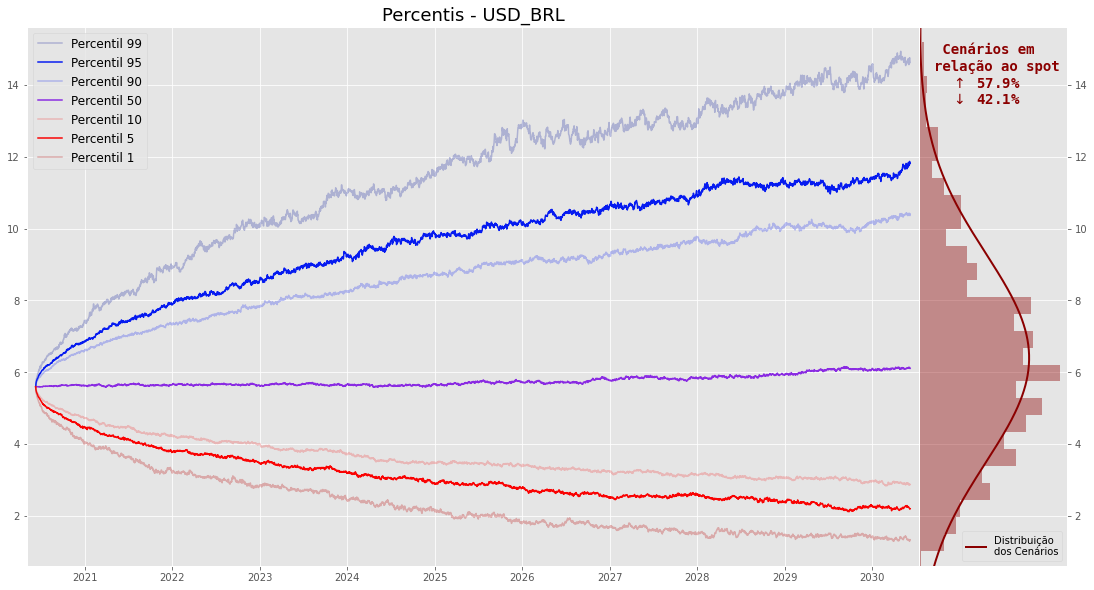

In [6]:
DICT_ALL_PERCENTILES = {}
for i in DICT_GBM:
    DICT_ALL_PERCENTILES[i] = (DICT_GBM[i]["percentis"])
for i in DICT_CIR:
    DICT_ALL_PERCENTILES[i] = (DICT_CIR[i]["percentis"])
for i in DICT_VASICEK:
    DICT_ALL_PERCENTILES[i] = (DICT_VASICEK[i]["percentis"])   
    
###########################################################################################
    
style = {'description_width': 'initial'}    

vol_box = widgets.FloatText(description='Volatility',style=style,disabled=True)
drift_box = widgets.FloatText(description='Drift',style=style,disabled=True)
reversion_speed_box = widgets.FloatText(description='Reversion Speed',style=style,disabled=True)
long_term_rate_box = widgets.FloatText(description='Long Term Rate',style=style,disabled=True)
botao_troca_ativo = widgets.Button(description='Plotar Percentis')
botao_recalcula_percentis = widgets.Button(description='Recalcular Percentis')
botao_reset = widgets.Button(description='Reset All')

###########################################################################################

ativos = list(DICT_ALL_PERCENTILES.keys())
dropdown_ativos = widgets.Dropdown(description='Ativo',options = ['']+ativos,value='')

if dropdown_ativos.value == '':
    vol_box.value = 0
    drift_box.value = 0
    reversion_speed_box.value = 0
    long_term_rate_box.value = 0  
  
    
elif dropdown_ativos.value in GBM_ATIVOS:
    ativo = dropdown_ativos.value
    vol_box.value = round(DICT_GBM[ativo]['daily_vol'],5)
    drift_box.value = round(DICT_GBM[ativo]['drift'],5)
    reversion_speed_box.value = 0
    long_term_rate_box.value = 0
    vol_box.disabled = False
    drift_box.disabled = False
    reversion_speed_box.disabled = True
    long_term_rate_box.disabled = True
    
elif dropdown_ativos.value in CIR_ATIVOS:
    ativo = dropdown_ativos.value
    vol_box.value = round(DICT_CIR[ativo]['daily_vol'],5)
    reversion_speed_box.value = round(DICT_CIR[ativo]['reversion_speed'],5)
    long_term_rate_box.value = round(DICT_CIR[ativo]['long_term_rate'],5)
    drift_box.value = 0
    vol_box.disabled = False
    drift_box.disabled = True
    reversion_speed_box.disabled = False
    long_term_rate_box.disabled = False
    
elif dropdown_ativos.value in VASICEK_ATIVOS:
    ativo = dropdown_ativos.value
    vol_box.value = round(DICT_VASICEK[ativo]['daily_vol'],5)
    reversion_speed_box.value = round(DICT_VASICEK[ativo]['reversion_speed'],5)
    long_term_rate_box.value = round(DICT_VASICEK[ativo]['long_term_rate'],5) 
    drift_box.value = 0
    vol_box.disabled = False
    drift_box.disabled = True
    reversion_speed_box.disabled = False
    long_term_rate_box.disabled = False
    
display(widgets.HBox([dropdown_ativos,botao_troca_ativo]))
display(widgets.HBox([reversion_speed_box,long_term_rate_box]))
display(widgets.HBox([vol_box,drift_box]))

botao_troca_ativo.on_click(plota_novo_ativo)
botao_recalcula_percentis.on_click(recalcula_percentis)     
botao_reset.on_click(reset_dicts)

## Verifica o espaço ocupado (em bytes) por todas as variáveis armazenadas no Notebook

Memória Total Alocada - 36620 bytes 
 


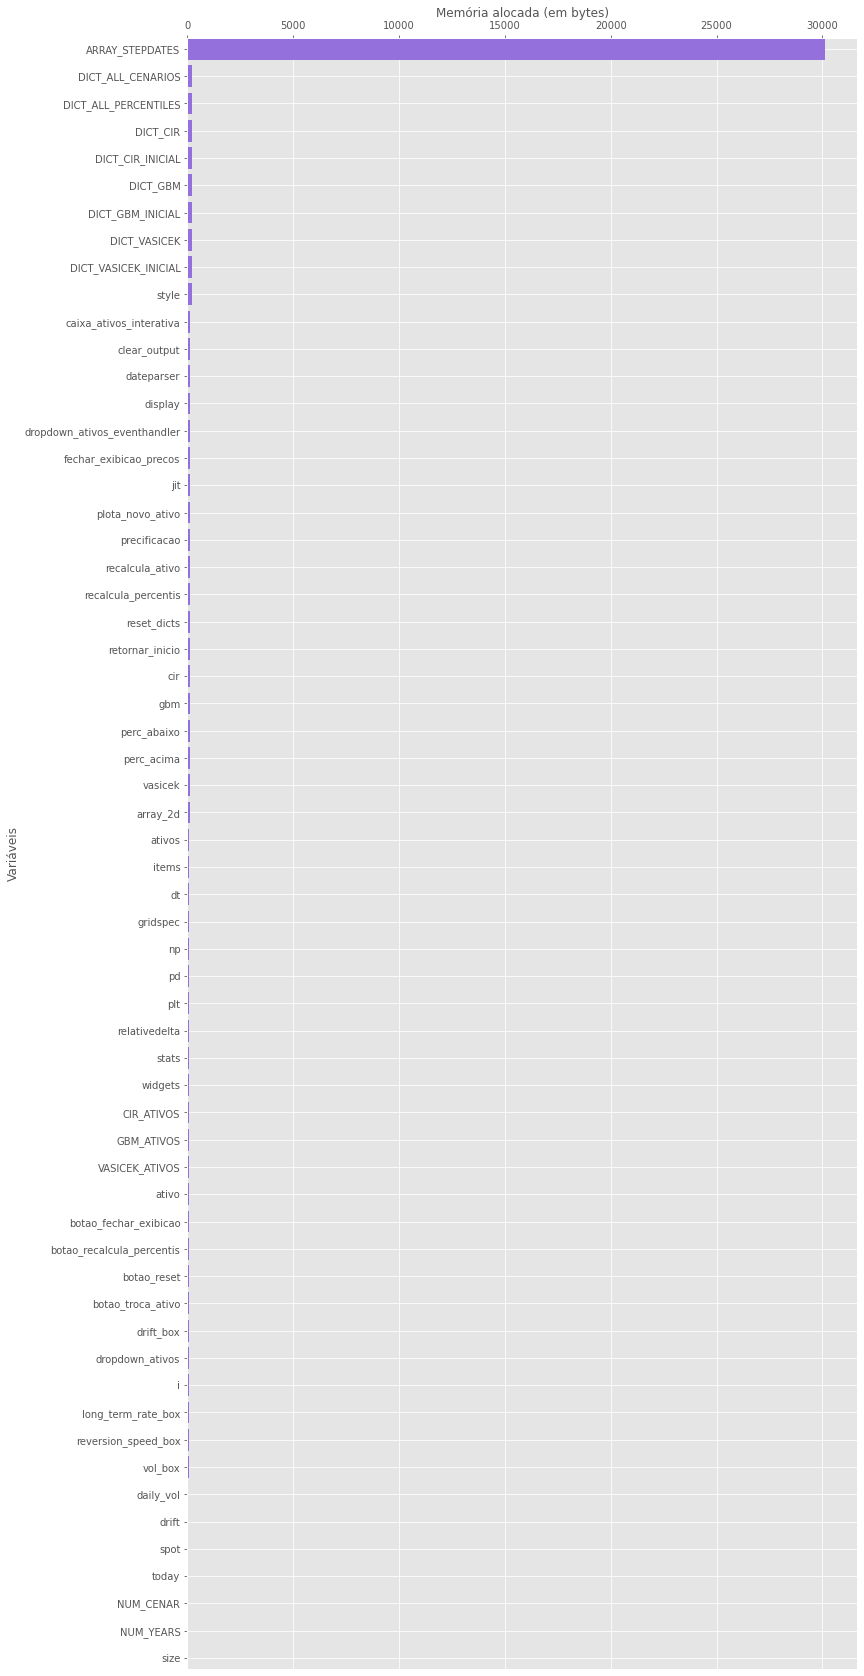

In [7]:
import sys
    
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

_all = sorted([[x, sys.getsizeof(globals().get(x))] for x in dir() \
        if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

variaveis = [_all[i][0] for i in range(len(_all))]
memoria_alocada = [_all[i][1] for i in range(len(_all))]

total_alocado = sum(memoria_alocada)

print("Memória Total Alocada - %d bytes \n "%total_alocado)

fig, ax = plt.subplots(figsize=(12,30))
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.barh(variaveis, memoria_alocada,color='#9370DB',log=False,linestyle='-.')
plt.xlabel("Memória alocada (em bytes)")
plt.ylabel("Variáveis")
plt.margins(y=0)
plt.show()
